# **Step by step WLNM algorithm**

## ✅ **Step 1: Running the WLNM algorithm (Main.m)**

### 🔹 **Purpose:**
This script controls the full WLNM pipeline for **training, evaluation, and logging** of link prediction experiments across food webs.

---

### 🔹 **What it does (High-level summary):**

| Section | Description |
|--------|-------------|
| **Configuration** | Sets `K`, train/test split ratio, and parallel options |
| **Load foodweb list** | Reads food web names from a CSV (e.g., `SF1M2`, `Chesapeake Bay`) |
| **Prepare logging** | Creates result and log folders, and initializes `.csv` for output |
| **Load .mat file** | Loads adjacency matrix (`net`), species (`taxonomy`), and `mass` |
| **Run experiments** | For each food web and each `K`, runs the WLNM pipeline |
| **Log results** | Saves AUC, threshold, precision, recall, F1-score to a CSV |

---

### 🔹 **Main Loop Workflow:**

```matlab
for each foodweb:
    for each K:
        for each experiment:
            1. Split train/test from net
            2. Run WLNM:
               - Sample positive/negative links
               - Extract enclosing subgraphs
               - Train feedforward neural network
               - Predict probabilities
               - Optimize threshold via F1-score
            3. Save results to CSV
```

---

### 🔹 **Output:**
For each food web, you get:

- `foodwebname_results.csv` containing:
  - `AUC`, `Precision`, `Recall`, `F1Score`, `Threshold`, `K`, and runtime

Example:
```csv
Iteration,AUC,ElapsedTime,K,TrainRatio,BestThreshold,Precision,Recall,F1Score
1,0.8618,00:00:18,10,90,0.90,0.0263,0.4353,0.0496
```

## ✅ **Step 1.1: Inspecting the properties of the food web (SF1M2)**

| Property               | How to compute in MATLAB                   | What it tells you                              | Output value    |
|------------------------|---------------------------------------------|-------------------------------------------------|--------|
| **Number of species**  | `n = size(net, 1);`                         | Total number of nodes (taxa)                    | 10     |
| **Number of links**    | `num_links = nnz(net);`                     | Number of directed interactions (edges)         | 16     |
| **Density** (connectance) | `connectance = nnz(net) / (n * (n - 1));` | Fraction of realized links among all possible  | 0.1778 |
| **Max/Min mass**       | `min(mass)`, `max(mass)`                   | Range of species body sizes                     | min=1.0000e-04, max=0.9877|
| **Mass distribution**  | `histogram(log10(mass))`                   | Log-scale mass spread (trait-based insights)    | NaN|
| **Top predators**      | `sum(net, 1)`                               | Columns with many 1s = predators with many prey | (1['Fucus'], 2['Gammarus oceanicus']) -> 4 |
|                        |                                             |                                                 | (1['Fucus'], 3['Littorina obtusata']) -> 3 |
|                        |                                             |                                                 | (1['Fucus'], 4['Littorina saxatilis'']) -> 3 |
|                        |                                             |                                                 | (1['Fucus'], 5['Mytilus sp.']) -> 2 |
|                        |                                             |                                                 | (1['Fucus'], 8['Polydora sp.']) -> 2 |
|                        |                                             |                                                 | (1['Fucus'], 10['Zooplankton']) -> 2 |
| **Basal species**      | `sum(net, 2)`                               | Rows with all 0s = species with no prey         | (1['Fucus'], 1['Fucus']) -> 4 |
|                        |                                             |                                                 | (6['Petalonia fascia'], 1['Fucus']) -> 4 |
|                        |                                             |                                                 | (7['PhytoP'], 1['Fucus']) -> 4 |
|                        |                                             |                                                 | (9['Ralfsia verrucosa'], 1['Fucus']) -> 4 |
|                        |                                             |                                                 | (10['Zooplankton'], 1['Fucus']) -> 4 |


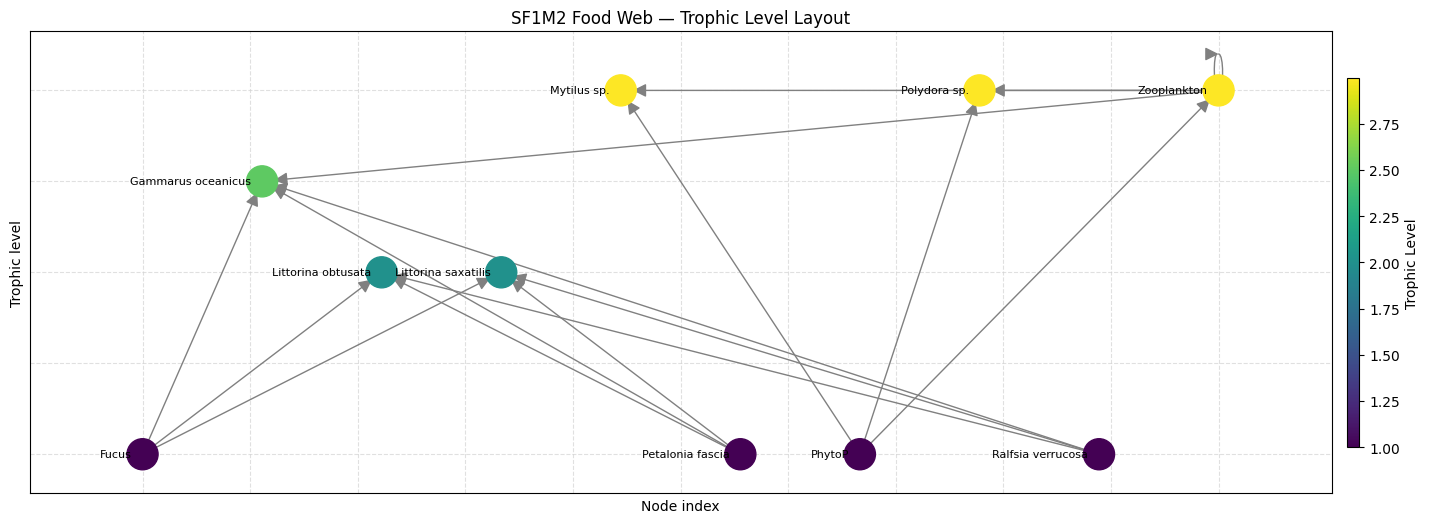

In [32]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx

# Load .mat file
mat = loadmat("/Users/jorge/Desktop/PhD/Code/ExtractFoodWebs/foodwebs_mat_by_ecosystem/MAT_mass/SF1M2_tax_mass.mat")
net = mat["net"].toarray()
taxonomy = [str(t[0]) for t in mat["taxonomy"].flatten()]

# Compute Prey-Averaged Trophic Level (PATL) method
def compute_trophic_levels(adj, max_iter=100):
    n = adj.shape[0]
    tl = np.ones(n)
    for _ in range(max_iter):
        denom = np.maximum(adj.sum(axis=0), 1)
        new_tl = 1 + (adj.T @ tl) / denom
        if np.allclose(new_tl, tl, atol=1e-6):
            break
        tl = new_tl
    return tl

# Calculate trophic levels
trophic_levels = compute_trophic_levels(net)

# Build directed graph (prey → predator)
G = nx.DiGraph()
for i in range(len(taxonomy)):
    G.add_node(i, label=taxonomy[i], trophic=trophic_levels[i])

# Add edges
for i in range(net.shape[0]):
    for j in range(net.shape[1]):
        if net[i, j] == 1:
            G.add_edge(i, j)

# Assign positions: Y = trophic level, X = evenly spaced
pos = {i: (i, G.nodes[i]["trophic"]) for i in G.nodes}

# Normalize and map trophic levels to colors
trophic_values = np.array([G.nodes[i]["trophic"] for i in G.nodes])
norm = mcolors.Normalize(vmin=trophic_values.min(), vmax=trophic_values.max())
cmap = plt.colormaps.get_cmap("viridis")
node_colors = [cmap(norm(t)) for t in trophic_values]

# Assign new X positions (spread out)
x_positions = np.linspace(0, 20, len(G.nodes))
pos = {i: (x_positions[i], G.nodes[i]["trophic"]) for i in G.nodes}

# Plot
plt.figure(figsize=(20, 6))

# Draw nodes and edges without labels
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=500)
nx.draw_networkx_edges(G, pos,
                       edge_color="gray",
                       arrows=True,
                       arrowsize=20)

# Draw custom-aligned labels to the right of nodes
label_pos = {k: (v[0] - 0.2, v[1]) for k, v in pos.items()}  # X offset
nx.draw_networkx_labels(G, label_pos,
                        labels={i: G.nodes[i]["label"] for i in G.nodes},
                        font_size=8,
                        horizontalalignment='right')

# Title and axis formatting
plt.title("SF1M2 Food Web — Trophic Level Layout")
plt.xlabel("Node index")
plt.ylabel("Trophic level")

# Grid and colorbar (unchanged)
ax = plt.gca()
ax.set_axisbelow(True)
ax.set_xticks(range(0, 21, 2))
ax.set_yticks(np.arange(np.floor(min(trophic_values)),
                        np.ceil(max(trophic_values)) + 0.5, 0.5))
ax.grid(True, which='both', linestyle='--', color='lightgray', alpha=0.7)
# ax.set_facecolor("whitesmoke")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, aspect=30)
cbar.set_label("Trophic Level")

plt.show()


In [34]:
# Re-import necessary packages after kernel reset
from scipy.io import loadmat
import numpy as np
import pandas as pd

# Load the SF1M2 data
mat = loadmat("/Users/jorge/Desktop/PhD/Code/ExtractFoodWebs/foodwebs_mat_by_ecosystem/MAT_mass/SF1M2_tax_mass.mat")
net = mat["net"].toarray()
taxonomy = [str(t[0]) for t in mat["taxonomy"].flatten()]

# Initial trophic levels (all start at 1)
tl_history = [np.ones(net.shape[0])]

# Iterative PATL calculation step-by-step
for _ in range(10):  # We'll limit to 10 steps for clarity
    prev_tl = tl_history[-1]
    denom = np.maximum(net.sum(axis=0), 1)  # prevent division by zero
    next_tl = 1 + (net.T @ prev_tl) / denom
    tl_history.append(next_tl)
    if np.allclose(next_tl, prev_tl, atol=1e-6):
        break

# Format into a DataFrame to show the progression step-by-step
tl_df = pd.DataFrame(np.array(tl_history), columns=taxonomy)
tl_df.index.name = "Iteration"
tl_df

,Fucus,Gammarus oceanicus,Littorina obtusata,Littorina saxatilis,Mytilus sp.,Petalonia fascia,PhytoP,Polydora sp.,Ralfsia verrucosa,Zooplankton
Iteration,,,,,,,,,,
0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000
1,1.0,2.000000,2.0,2.0,2.000000,1.0,1.0,2.000000,1.0,2.000000
2,1.0,2.250000,2.0,2.0,2.500000,1.0,1.0,2.500000,1.0,2.500000
3,1.0,2.375000,2.0,2.0,2.750000,1.0,1.0,2.750000,1.0,2.750000
4,1.0,2.437500,2.0,2.0,2.875000,1.0,1.0,2.875000,1.0,2.875000
5,1.0,2.468750,2.0,2.0,2.937500,1.0,1.0,2.937500,1.0,2.937500
6,1.0,2.484375,2.0,2.0,2.968750,1.0,1.0,2.968750,1.0,2.968750
7,1.0,2.492188,2.0,2.0,2.984375,1.0,1.0,2.984375,1.0,2.984375
8,1.0,2.496094,2.0,2.0,2.992188,1.0,1.0,2.992188,1.0,2.992188


## ✅ **Step 2: Dividing the network into training and testing sets**  
### Function: `DivideNet(net, ratioTrain)`

---

### 🔹 **Purpose**:
Splits the input **directed food web** into two subsets:
- `train`: used for learning link patterns in WLNM
- `test`: held out for evaluating model predictions

This process:
- **Preserves directionality** (e.g., prey → predator)
- **Removes self-loops**
- Is **reproducible** via a fixed random seed

---

### 🔹 **Inputs:**
| Variable     | Description |
|--------------|-------------|
| `net`        | Directed binary adjacency matrix (asymmetric) |
| `ratioTrain` | Proportion of existing links to retain for training (e.g., `0.9`) |

---

### 🔹 **Outputs:**
| Variable | Description |
|----------|-------------|
| `train`  | Sparse, directed matrix of links used during training |
| `test`   | Sparse, directed matrix of links used for evaluation |

---

### 🔹 **How it works (Step-by-step):**

| Step | Description |
|------|-------------|
| 1.   | Extract all directed edges `(i → j)` from `net` |
| 2.   | **Remove self-loops** where `i == j` |
| 3.   | Shuffle the list of edges using `rng(42)` to ensure reproducibility |
| 4.   | Split the list into two sets: first portion becomes `test`, remainder becomes `train` |
| 5.   | Convert both lists into **sparse adjacency matrices**, maintaining direction |

---

### ✅ Key Improvements Over the Old Version

| Old `DivideNet`                                   | New `DivideNet`                                 |
|---------------------------------------------------|--------------------------------------------------|
| Used `triu(net)` → lost directional structure     | ✅ Retains full **directed** graph               |
| Symmetrized all output (i.e., `net + net'`)       | ✅ Keeps original edge direction `(i → j)`       |
| Self-loops were not removed                       | ✅ Removes self-loops automatically              |
| No control over random seed                       | ✅ Uses `rng(42)` for reproducible splits        |
| Included unused connectivity checks               | ✅ Clean and efficient for ML workflows          |

---

### 🧠 Why it matters in ecological ML:
- Food webs are inherently **directional** — prey ≠ predator
- WLNM is a **link prediction task**, not a simulation — so reachability constraints aren't necessary
- Consistency and simplicity = better tracking, testing, and publication-ready methods

## ✅ **Step 2.1: Train/test split + Summary metrics**

### 🔹 `Expected train ratio`
This is what **you requested** when calling `DivideNet`, e.g.:

```matlab
ratioTrain = 0.9;
```

You’re telling the function:  
> “Please use **90% of the links** for training, and the rest for testing.”

---

### 🔹 `Actual train ratio` and `test ratio`
These show **what really happened** after the split, because:

- The number of links is **discrete**
- `ceil()` or `round()` may slightly shift proportions
- Self-loops may be removed, affecting the base count

---

### ✅ Formula

If you have:
- `N_total` = total usable links (after removing self-loops)
- `N_train` = links used in training
- `N_test` = links used in testing

Then:

```python
actual_train_ratio = N_train / (N_train + N_test)
actual_test_ratio = N_test / (N_train + N_test)
```

---

### 🧠 Why these ratios might differ from your `ratioTrain`:

| Reason | Example |
|--------|---------|
| Small total link count | 15 links: 90% = 13.5 → rounded to 13 |
| Edge rounding | 90% may yield 86.7% in practice |
| Self-loop removal | Reduces the pool of valid links |
| Random split edge case | For tiny test sets, even 1 link shifts the ratio significantly |

---

### ✅ Why they matter

| Metric | Interpretation |
|--------|----------------|
| `Expected train ratio` | What you *asked for* |
| `Actual train ratio`   | What you *got* |
| Difference             | Helps catch split bugs or data imbalance |

In [5]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

# Load the .mat file
mat = loadmat("/Users/jorge/Desktop/PhD/Code/ExtractFoodWebs/foodwebs_mat_by_ecosystem/MAT_mass/SF1M2_tax_mass.mat")
net = mat["net"].toarray()
taxonomy = [str(t[0]) for t in mat["taxonomy"].flatten()]

# Remove self-loops
np.fill_diagonal(net, 0)

# Extract directed edges
i, j = np.where(net == 1)
linklist = np.column_stack((i, j))

# Set training ratio
ratioTrain = 0.9

# Shuffle and split
np.random.seed(42)
perm = np.random.permutation(len(linklist))
num_test = int(np.ceil((1 - ratioTrain) * len(linklist)))
test_links = linklist[perm[:num_test]]
train_links = linklist[perm[num_test:]]

# Show link labels
train_df = pd.DataFrame(train_links, columns=["Prey_idx", "Predator_idx"])
test_df = pd.DataFrame(test_links, columns=["Prey_idx", "Predator_idx"])
train_df["Prey"] = [taxonomy[i] for i in train_df["Prey_idx"]]
train_df["Predator"] = [taxonomy[j] for j in train_df["Predator_idx"]]
test_df["Prey"] = [taxonomy[i] for i in test_df["Prey_idx"]]
test_df["Predator"] = [taxonomy[j] for j in test_df["Predator_idx"]]

# Show combined labeled split (optional)
split_df = pd.concat([
    train_df.assign(Set="Train"),
    test_df.assign(Set="Test")
])
split_df

,Prey_idx,Predator_idx,Prey,Predator,Set
0,0,1,Fucus,Gammarus oceanicus,Train
1,9,4,Zooplankton,Mytilus sp.,Train
2,5,3,Petalonia fascia,Littorina saxatilis,Train
3,6,9,PhytoP,Zooplankton,Train
4,0,3,Fucus,Littorina saxatilis,Train
5,0,2,Fucus,Littorina obtusata,Train
6,9,7,Zooplankton,Polydora sp.,Train
7,5,2,Petalonia fascia,Littorina obtusata,Train
8,6,7,PhytoP,Polydora sp.,Train
9,8,2,Ralfsia verrucosa,Littorina obtusata,Train


In [3]:
# Metric summary
actual_train_links = len(train_links)
actual_test_links = len(test_links)
total_links = actual_train_links + actual_test_links
actual_train_ratio = actual_train_links / total_links
actual_test_ratio = actual_test_links / total_links

metric_table = pd.DataFrame({
    "Metric": [
        "Total links",
        "Training links",
        "Testing links",
        "Expected train ratio",
        "Actual train ratio",
        "Actual test ratio"
    ],
    "Value": [
        total_links,
        actual_train_links,
        actual_test_links,
        round(ratioTrain, 2),
        round(actual_train_ratio, 2),
        round(actual_test_ratio, 2)
    ]
})
metric_table

,Metric,Value
0,Total links,15.00
1,Training links,13.00
2,Testing links,2.00
3,Expected train ratio,0.90
4,Actual train ratio,0.87
5,Actual test ratio,0.13


## ✅ **Step 3: Sampling Positive and Negative Links for Training and Testing**
### Function: `WLNM(...)`  
(*which internally calls `sample_neg(...)` and `graph2vector(...)`*)

---

### 🔹 **Purpose**:
Prepare the **feature matrix** and **label vector** required to train the WLNM neural network.

This step:
- Extracts **positive** (existing) and **negative** (non-existing) links
- Builds the training and test datasets
- Encodes local graph structures around those links

---

### 🔹 **Inputs from previous steps:**
| Variable   | Description |
|------------|-------------|
| `train`    | Directed adjacency matrix with known (positive) links |
| `test`     | Directed matrix with held-out links (for evaluation) |
| `K`        | Number of vertices in enclosing subgraph |
| `taxonomy` | Species names |
| `mass`     | Mean mass per species |

---

### 🔹 **What it does (step-by-step)**

| Step | Description |
|------|-------------|
| 1.   | `train` and `test` are passed to `sample_neg(...)` |
| 2.   | For each set (`train`, `test`), the code samples: <br> → Positive links: from real data <br> → Negative links: from links **not in the graph** |
| 3.   | These links are passed to `graph2vector(...)`, which encodes their **K-hop subgraphs** as vectors (features) |
| 4.   | These vectors are passed to a **feedforward neural network** (fully connected layers) |
| 5.   | The trained network is used to **predict test links** and assign a probability score |
| 6.   | Precision/recall/F1 and AUC are computed based on **binary classification** and thresholding |

---

### ✅ Directed Graph Compatibility

This version of WLNM **fully supports directed graphs**, because:
- You pass `train` and `test` directly as they were returned from `DivideNet`
- There's **no symmetrization** or `+ train'` involved anymore

✅ Just make sure:
- `sample_neg()` is treating links as directed (i.e., if `(i, j)` is in `train`, `(j, i)` should still be eligible as negative if not present)

---

### ✅ Summary Table

| Stage            | Purpose                               | Preserves Directionality? |
|------------------|----------------------------------------|----------------------------|
| `DivideNet`      | Produces directed train/test           | ✅ Yes                     |
| `sample_neg`     | Generates positive/negative examples   | ⚠️ Must be double-checked  |
| `graph2vector`   | Encodes K-hop subgraphs                | ✅ (depends on adjacency input) |
| WLNM NN          | Learns from encoded features           | ✅ Uses provided features  |
| Evaluation       | Threshold-based + AUC computation      | ✅ Based on predictions    |

## ✅ **Step 4: Sampling negative links**  
### Function: `sample_neg(train, test, k, portion, evaluate_on_all_unseen)`

---

### 🔹 **Purpose**:
Creates **negative samples** (non-existing links) for **training** and **testing**.  
Essential for **binary classification**: the model must learn to distinguish between real (positive) and fake (negative) links.

---

### 🔹 **Inputs:**

| Variable               | Description |
|-------------------------|-------------|
| `train`                 | Adjacency matrix of positive training links |
| `test`                  | Adjacency matrix of positive testing links |
| `k`                     | Negative sampling factor (e.g., `k=2` → 2× more negatives) |
| `portion`               | Subsampling rate (e.g., `0.8`) or number |
| `evaluate_on_all_unseen`| If true, **test** on **all unseen** links instead of sampling |

---

### 🔹 **Outputs:**

| Variable     | Description |
|--------------|-------------|
| `train_pos`  | Positive training links (i → j pairs) |
| `train_neg`  | Negative training links |
| `test_pos`   | Positive testing links |
| `test_neg`   | Negative testing links |

---

### 🔹 **How it works (Step-by-step):**

| Step | Action |
|------|--------|
| 1. | **Extract** `(i,j)` pairs for positive training and testing links |
| 2. | **Build** a full positive network = `train + test` |
| 3. | **Identify** negatives = all `(i,j)` pairs not in positives and not self-loops |
| 4. | **Sample** `k × (#pos_train + #pos_test)` negative links |
| 5. | **Split** sampled negatives into `train_neg` and `test_neg` |
| 6. | **Subsample** if `portion < 1` (optional) |
| 7. | **Return** separated positives and negatives |

---

### 🔹 **Special options:**

- If `evaluate_on_all_unseen = true`,  
  → the **test_neg** set = **all unseen links** (not a random subset).  
  → This creates a much **harder, realistic** evaluation.

- `rng(42)` is used for **reproducibility** of the random sampling.

---

### ✅ Improvements over the original version:

| Old `sample_neg`                     | New `sample_neg` |
|---------------------------------------|------------------|
| No reproducibility                    | ✅ Controlled randomness (`rng(42)`) |
| Complex / unclear division            | ✅ Simple clear split (train/test negatives) |
| No self-loop removal                  | ✅ Properly removes self-links |
| Risk of crash if negatives < needed   | ✅ Auto-adjusts `k` downward if needed |
| No portion control                    | ✅ Full support for portion filtering |

## ✅ **Step 5: Encoding subgraphs into vectors**  
### Function: `graph2vector(pos, neg, A, K, useParallel)`

---

### 🔹 **Purpose**:
Converts each sampled **positive** and **negative link** into a **fixed-size feature vector**  
based on the **local subgraph** structure around the link.

These vectors are used to **train the link prediction model** later.

---

### 🔹 **Inputs:**

| Variable      | Description |
|---------------|-------------|
| `pos`         | List of positive links (i → j) |
| `neg`         | List of negative links |
| `A`           | Original directed adjacency matrix |
| `K`           | Size of enclosing subgraph to extract |
| `useParallel` | Boolean flag to activate parallel pool |

---

### 🔹 **Outputs:**

| Variable | Description |
|----------|-------------|
| `data`   | Feature matrix (each row = one link vector) |
| `label`  | Labels (1 = positive link, 0 = negative link) |

---

### 🔹 **How it works (Step-by-step):**

| Step | Action |
|------|--------|
| 1. | Concatenate positive and negative links together |
| 2. | Generate labels: 1 for positives, 0 for negatives |
| 3. | For each link: |
| 3.1 | Expand a **local subgraph** around the link |
| 3.2 | Apply a **graph labeling algorithm** to reorder nodes |
| 3.3 | Encode the reordered adjacency matrix (upper triangle) into a **fixed-size vector** |
| 4. | Assemble the vectors into a full dataset |

---

### 🔹 **Special features:**

| Feature | Description |
|---------|-------------|
| **Directed graphs** | Fully preserved (no symmetrization) |
| **Depth-limited** | Stops expansion at a maximum depth (default = 5) |
| **Duplicate prevention** | No redundant subgraph nodes |
| **Parallel support** | Can massively speed up feature encoding |
| **Reproducibility** | Parallel runs give consistent outputs |

---

### ✅ Improvements over the original WLNM:

| Old `graph2vector`                       | New `graph2vector`                  |
|-------------------------------------------|-------------------------------------|
| Only undirected expansion                 | ✅ Correctly expands directed neighbors |
| No depth control                          | ✅ Controlled maximum fringe depth |
| No duplicate removal (inefficient)        | ✅ Fast deduplication with `containers.Map` |
| Single-threaded only                      | ✅ Parallel option for CPUs |
| Unchecked node overflow                   | ✅ Stops after reaching K nodes exactly |
| Potential inconsistencies on multiple runs| ✅ Stable and reproducible encoding |

## ✅ **Step 6: Training the FNN Classifier**  
### Function: `WLNM(dataname, train, test, K, taxonomy, mass)`

---

### 🔹 **Purpose**:
Train a **Feedforward Neural Network** (FNN) to classify whether a link exists (1) or not (0) based on the **local subgraph structure** encoded into a vector.

This is the core learning step of the **WLNM** pipeline.

---

### 🔹 **Inputs:**

| Variable      | Description |
|---------------|-------------|
| `dataname`    | Name of the food web (for saving outputs) |
| `train`       | Sparse matrix of directed training links |
| `test`        | Sparse matrix of directed testing links |
| `K`           | Size of enclosing subgraph (fixed for all links) |
| `taxonomy`    | Species names (for exporting metadata) |
| `mass`        | Species mass values (for metadata) |

---

### 🔹 **Outputs:**

| Variable           | Description |
|--------------------|-------------|
| `auc`              | Area Under the ROC Curve (overall model quality) |
| `best_threshold`   | Optimal probability threshold for classification |
| `best_precision`   | Precision at best threshold |
| `best_recall`      | Recall at best threshold |
| `best_f1_score`    | F1-Score at best threshold |

---

### 🔹 **How it works (Step-by-step):**

| Step | Action |
|------|--------|
| 1. | Sample **positive** and **negative** links for both train and test |
| 2. | Encode links into **fixed-size subgraph feature vectors** |
| 3. | Define a **shallow feedforward neural network** architecture |
| 4. | Train the network on the training set |
| 5. | Predict **probabilities** for the test set |
| 6. | Compute **ROC-AUC** to assess classifier quality |
| 7. | **Search best threshold** that maximizes F1-Score |
| 8. | Save scores, labels, and classified links (TP, FP, FN) |

---

### 🔹 **Neural Network Architecture**:

| Layer | Details |
|-------|---------|
| Input | 1D vector of size \( \frac{K(K-1)}{2} \) |
| Dense1 | 32 units, ReLU |
| Dense2 | 32 units, ReLU |
| Dense3 | 16 units, ReLU |
| Output | 2 units (binary classification: link / no-link), Softmax |

- Optimizer: **SGD with momentum (sgdm)**  
- Learning Rate: **Piecewise Decay**
- Mini-batch size: **128**
- Epochs: **200**

---

### ✅ **Special Features:**

| Feature                  | Description |
|---------------------------|-------------|
| **Parallel Subgraph Encoding** | Faster feature extraction when `useParallel = true` |
| **Softmax Output**             | Produces real-valued link existence probabilities |
| **AUC Computation**            | Independent of any threshold selection |
| **Threshold Optimization**     | Post-training sweep to maximize F1 |
| **Result Export**              | TP, FP, FN exported to CSV for later visualization |

---

### ✅ **Summary Flow for WLNM Training**:

```
Sparse train/test matrices
       ↓
  Sample positive and negative links
       ↓
 Encode each link's local subgraph (graph2vector)
       ↓
 Feed into neural network
       ↓
 Predict probabilities
       ↓
 Compute AUC and optimize threshold
       ↓
 Save all results
```